In [2]:
import pandas as pd

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt 

In [4]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

In [5]:
pd.__version__

'2.2.2'

In [6]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("my-exp")

<Experiment: artifact_location='/workspaces/traffic-prediction/mlruns/1', creation_time=1716271251003, experiment_id='1', last_update_time=1716271251003, lifecycle_stage='active', name='my-exp', tags={}>

In [4]:
!pip install pyarrow

     |████████████████████████████████| 40.8 MB 80 kB/s  eta 0:00:01    |█▎                              | 1.6 MB 1.0 MB/s eta 0:00:380:22     |████████████████▋               | 21.1 MB 1.0 MB/s eta 0:00:19�           | 26.7 MB 1.0 MB/s eta 0:00:14


In [7]:
df = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-01.parquet')

In [8]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,2,2024-01-01 00:57:55,2024-01-01 01:17:43,1.0,1.72,1.0,N,186,79,2,17.7,1.0,0.5,0.00,0.0,1.0,22.70,2.5,0.0
1,1,2024-01-01 00:03:00,2024-01-01 00:09:36,1.0,1.80,1.0,N,140,236,1,10.0,3.5,0.5,3.75,0.0,1.0,18.75,2.5,0.0
2,1,2024-01-01 00:17:06,2024-01-01 00:35:01,1.0,4.70,1.0,N,236,79,1,23.3,3.5,0.5,3.00,0.0,1.0,31.30,2.5,0.0
3,1,2024-01-01 00:36:38,2024-01-01 00:44:56,1.0,1.40,1.0,N,79,211,1,10.0,3.5,0.5,2.00,0.0,1.0,17.00,2.5,0.0
4,1,2024-01-01 00:46:51,2024-01-01 00:52:57,1.0,0.80,1.0,N,211,148,1,7.9,3.5,0.5,3.20,0.0,1.0,16.10,2.5,0.0


In [9]:
df.tpep_dropoff_datetime = pd.to_datetime(df.tpep_dropoff_datetime)
df.tpep_pickup_datetime = pd.to_datetime(df.tpep_pickup_datetime)


In [10]:
df['duration']= df.tpep_dropoff_datetime - df.tpep_pickup_datetime

In [11]:
df

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,duration
0,2,2024-01-01 00:57:55,2024-01-01 01:17:43,1.0,1.72,1.0,N,186,79,2,17.70,1.00,0.5,0.00,0.00,1.0,22.70,2.5,0.0,0 days 00:19:48
1,1,2024-01-01 00:03:00,2024-01-01 00:09:36,1.0,1.80,1.0,N,140,236,1,10.00,3.50,0.5,3.75,0.00,1.0,18.75,2.5,0.0,0 days 00:06:36
2,1,2024-01-01 00:17:06,2024-01-01 00:35:01,1.0,4.70,1.0,N,236,79,1,23.30,3.50,0.5,3.00,0.00,1.0,31.30,2.5,0.0,0 days 00:17:55
3,1,2024-01-01 00:36:38,2024-01-01 00:44:56,1.0,1.40,1.0,N,79,211,1,10.00,3.50,0.5,2.00,0.00,1.0,17.00,2.5,0.0,0 days 00:08:18
4,1,2024-01-01 00:46:51,2024-01-01 00:52:57,1.0,0.80,1.0,N,211,148,1,7.90,3.50,0.5,3.20,0.00,1.0,16.10,2.5,0.0,0 days 00:06:06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2964619,2,2024-01-31 23:45:59,2024-01-31 23:54:36,NaN,3.18,NaN,None,107,263,0,15.77,0.00,0.5,2.00,0.00,1.0,21.77,NaN,NaN,0 days 00:08:37
2964620,1,2024-01-31 23:13:07,2024-01-31 23:27:52,NaN,4.00,NaN,None,114,236,0,18.40,1.00,0.5,2.34,0.00,1.0,25.74,NaN,NaN,0 days 00:14:45
2964621,2,2024-01-31 23:19:00,2024-01-31 23:38:00,NaN,3.33,NaN,None,211,25,0,19.97,0.00,0.5,0.00,0.00,1.0,23.97,NaN,NaN,0 days 00:19:00
2964622,2,2024-01-31 23:07:23,2024-01-31 23:25:14,NaN,3.06,NaN,None,107,13,0,23.88,0.00,0.5,5.58,0.00,1.0,33.46,NaN,NaN,0 days 00:17:51


In [12]:
df.duration = df.duration.apply(lambda td: td.total_seconds()/60)

In [13]:
df

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,duration
0,2,2024-01-01 00:57:55,2024-01-01 01:17:43,1.0,1.72,1.0,N,186,79,2,17.70,1.00,0.5,0.00,0.00,1.0,22.70,2.5,0.0,19.800000
1,1,2024-01-01 00:03:00,2024-01-01 00:09:36,1.0,1.80,1.0,N,140,236,1,10.00,3.50,0.5,3.75,0.00,1.0,18.75,2.5,0.0,6.600000
2,1,2024-01-01 00:17:06,2024-01-01 00:35:01,1.0,4.70,1.0,N,236,79,1,23.30,3.50,0.5,3.00,0.00,1.0,31.30,2.5,0.0,17.916667
3,1,2024-01-01 00:36:38,2024-01-01 00:44:56,1.0,1.40,1.0,N,79,211,1,10.00,3.50,0.5,2.00,0.00,1.0,17.00,2.5,0.0,8.300000
4,1,2024-01-01 00:46:51,2024-01-01 00:52:57,1.0,0.80,1.0,N,211,148,1,7.90,3.50,0.5,3.20,0.00,1.0,16.10,2.5,0.0,6.100000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2964619,2,2024-01-31 23:45:59,2024-01-31 23:54:36,NaN,3.18,NaN,None,107,263,0,15.77,0.00,0.5,2.00,0.00,1.0,21.77,NaN,NaN,8.616667
2964620,1,2024-01-31 23:13:07,2024-01-31 23:27:52,NaN,4.00,NaN,None,114,236,0,18.40,1.00,0.5,2.34,0.00,1.0,25.74,NaN,NaN,14.750000
2964621,2,2024-01-31 23:19:00,2024-01-31 23:38:00,NaN,3.33,NaN,None,211,25,0,19.97,0.00,0.5,0.00,0.00,1.0,23.97,NaN,NaN,19.000000
2964622,2,2024-01-31 23:07:23,2024-01-31 23:25:14,NaN,3.06,NaN,None,107,13,0,23.88,0.00,0.5,5.58,0.00,1.0,33.46,NaN,NaN,17.850000


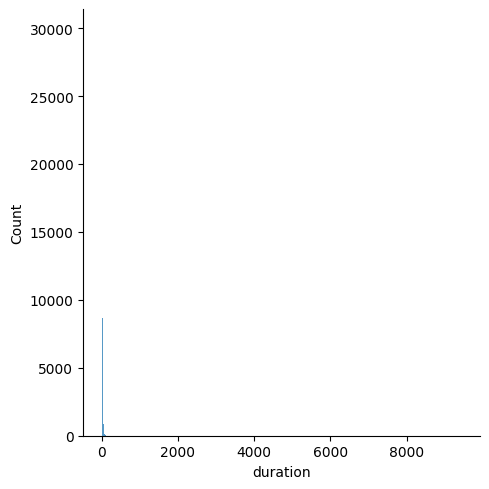

In [14]:
sns.displot(df.duration)

In [15]:
df= df[(df.duration >= 1) & (df.duration <= 60)]

In [16]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

In [17]:
df[categorical] = df[categorical].astype(str)

/tmp/ipykernel_21303/1767203464.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[categorical] = df[categorical].astype(str)


In [18]:
df[categorical + numerical]

,PULocationID,DOLocationID,trip_distance
0,186,79,1.72
1,140,236,1.80
2,236,79,4.70
3,79,211,1.40
4,211,148,0.80
...,...,...,...
2964619,107,263,3.18
2964620,114,236,4.00
2964621,211,25,3.33
2964622,107,13,3.06


In [19]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

In [20]:
train_dicts

[{'PULocationID': '186', 'DOLocationID': '79', 'trip_distance': 1.72},
 {'PULocationID': '140', 'DOLocationID': '236', 'trip_distance': 1.8},
 {'PULocationID': '236', 'DOLocationID': '79', 'trip_distance': 4.7},
 {'PULocationID': '79', 'DOLocationID': '211', 'trip_distance': 1.4},
 {'PULocationID': '211', 'DOLocationID': '148', 'trip_distance': 0.8},
 {'PULocationID': '148', 'DOLocationID': '141', 'trip_distance': 4.7},
 {'PULocationID': '138', 'DOLocationID': '181', 'trip_distance': 10.82},
 {'PULocationID': '246', 'DOLocationID': '231', 'trip_distance': 3.0},
 {'PULocationID': '161', 'DOLocationID': '261', 'trip_distance': 5.44},
 {'PULocationID': '113', 'DOLocationID': '113', 'trip_distance': 0.04},
 {'PULocationID': '107', 'DOLocationID': '137', 'trip_distance': 0.75},
 {'PULocationID': '158', 'DOLocationID': '246', 'trip_distance': 1.2},
 {'PULocationID': '246', 'DOLocationID': '190', 'trip_distance': 8.2},
 {'PULocationID': '68', 'DOLocationID': '90', 'trip_distance': 0.4},
 {'PU

In [21]:
dv = DictVectorizer()

In [22]:
X_train = dv.fit_transform(train_dicts)


In [23]:
X_train

<2898906x519 sparse matrix of type '<class 'numpy.float64'>'
	with 8696718 stored elements in Compressed Sparse Row format>

In [24]:
target = 'duration'
y_train = df[target].values

In [25]:
y_train

array([19.8       ,  6.6       , 17.91666667, ..., 19.        ,
       17.85      , 15.08333333])

In [25]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [26]:
y_pred = lr.predict(X_train)

/tmp/ipykernel_8275/4107668193.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label = 'prediction')
/tmp/ipykernel_8275/4107668193.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label = 'actual')


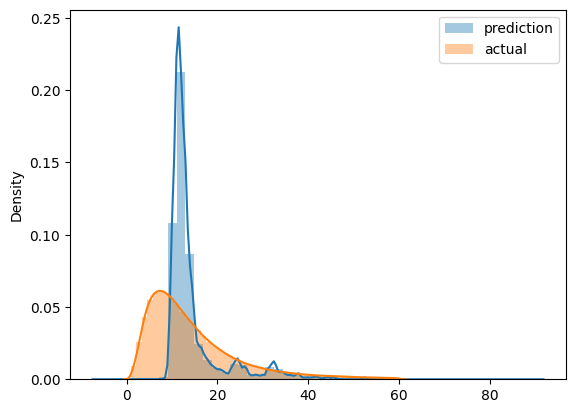

In [27]:
sns.distplot(y_pred, label = 'prediction')
sns.distplot(y_train, label = 'actual')

plt.legend()

In [28]:
mean_squared_error(y_train, y_pred, squared= False)

/home/codespace/anaconda3/envs/env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


7.952029670782532

In [29]:
import pickle

In [31]:
with open('/workspaces/traffic-prediction/models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [26]:
with mlflow.start_run():
    
    mlflow.set_tag("developer", "krishna")
    
    alpha = 0.001
    mlflow.log_param("alpha", alpha)
    lr=Lasso(alpha)
    lr.fit(X_train, y_train)
    
    y_pred = lr.predict(X_train)
    rmse = mean_squared_error(y_train, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)
    mlflow.log_artifact(local_paths = "/workspaces/traffic-prediction/models/lin_reg.bin", artifact_path="models_pickle/")

/home/codespace/anaconda3/envs/env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


TypeError: log_artifact() got an unexpected keyword argument 'local_paths'